In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import os.path
os.environ['USE_PYGEOS'] = '0'
import xarray as xr
import numpy as np
import pandas as pd
import fiona
import glob
import dask_geopandas
import geopandas as gpd
import time
from copy import deepcopy
from functools import reduce
import cftime

import dask
from dask.distributed import Client
from dask.diagnostics import ProgressBar


# client = Client(n_workers=2)

project_dir = '/home3/dth2133/data/clim_data_requests/maya'

In [4]:
from aggfly import regions
from aggfly import dataset, regions, grid_weights

# from aggfly.aggregate import TemporalAggregator, SpatialAggregator

ProgressBar().register()

In [5]:
from aggfly.aggregate import TemporalAggregator, SpatialAggregator

In [6]:
# Years to aggregate
years = np.arange(1951,1952)
years = years[years != 1959]

In [7]:
# Load shapefile
georegions = regions.from_path(
    "/home3/dth2133/data/shapefiles/county/cb_2018_us_county_500k.shp",
    regionid='GEOID'
)

In [30]:
def preprocess_era5l(array):
    # Function for cleaning the era5l data.
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):   
        # Reformat longitude
        array.coords['longitude'] = (array.coords['longitude'] + 180) % 360 - 180
        array = array.sortby(array.longitude)
        # Kelvin -> Celsius
        array = array - 273.15
    return array

# Open example dataset to construct weights.
clim = dataset.from_path(
    f"/home3/dth2133/data/usa/usa-t2m_tempPrecLand2019.zarr", 
    var = 't2m',
    engine = 'zarr',
    name='era5',
    clip_geom=georegions,
    preprocess = preprocess_era5l
)

# Calculate area and pop layer weights.
weights = grid_weights.from_objects(
    clim,
    georegions,
    wtype=None,
    simplify=0.001,
    project_dir=project_dir)

clim.clip_data_to_georegions_extent(georegions)

print("Loading weights")
w = weights.weights()
nzw_ind = np.isin(clim.grid.index, w.cell_id).nonzero()

/home3/dth2133/data/clim_data_requests/maya/tmp/GridWeights/mod-f5e7eeeb4ff91a1
Loading weights
Loading rescaled weights from cache
Cache dictionary:
{'func': 'weights', 'raster_weights': None}


In [9]:
print("Scheduling aggregation")
dailies = [
    TemporalAggregator('dd', 'time.date', ddargs=[-99,20,1]),
    TemporalAggregator('dd', 'time.date', ddargs=[20,99,0]),
    TemporalAggregator('avg', 'time.date'),
    TemporalAggregator('min', 'time.date'),
    TemporalAggregator('max', 'time.date')
]
monthly = TemporalAggregator('sum', 'time.month')

Scheduling aggregation


[########################################] | 100% Completed |  0.5s


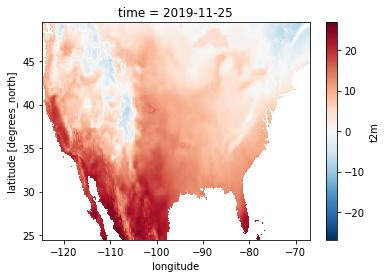

In [33]:
clim.da.sel(time = clim.da.time[0]).plot()

In [31]:
out = pd.DataFrame()
for year in years:
    print(year)
    start = time.time()

    print('Loading climate data')
    clim = dataset.from_path(
        f"/home3/dth2133/data/usa/usa-t2m_tempPrecLand{year}.zarr", 
        var = 't2m',
        engine = 'zarr',
        name='era5',
        clip_geom=georegions,
        preprocess = preprocess_era5l)
    clim.update(clim.da.persist())

    print('Aggregating')
    day_ds = [x.map_execute(clim, nzw_ind) for x in dailies]
    month_ds = [monthly.map_execute(x, nzw_ind) for x in day_ds]

    names = ['HDD_20C', 'CDD_20C', 'avg', 'min', 'max']
    df = SpatialAggregator(month_ds, w, weights.grid, names=names).compute()
    
    # Clean output dataset and append
    df = df.reset_index().rename(columns={'time':'month'})
    df['year'] = year
    df = df[['region_id', 'year', 'month'] + names]
    df = georegions.shp[['GEOID']].merge(df, left_index=True, right_on='region_id')

    out = pd.concat([out, df])

1951
Loading climate data
[########################################] | 100% Completed | 23.83 s
Aggregating
[########################################] | 100% Completed | 8.04 ss
[########################################] | 100% Completed | 80.74 ss


In [15]:
out.reset_index().to_feather("/home3/dth2133/data/clim_data_requests/maya/temp_data_maya.feather")

<Axes: >

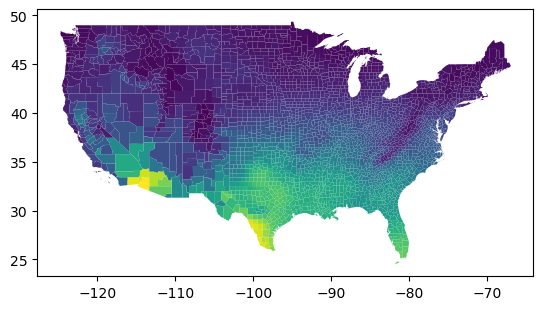

In [35]:
slc = out.loc[out.year==1951].groupby('GEOID').mean()
georegions.shp.merge(slc, right_index=True, left_on='GEOID').plot(column='CDD_20C')